# A quick introduction to Blackjax

BlackJAX is an MCMC sampling library based on [JAX](https://github.com/google/jax). BlackJAX provides well-tested and ready to use sampling algorithms. It is also explicitly designed to be modular: it is easy for advanced users to mix-and-match different metrics, integrators, trajectory integrations, etc.

In this notebook we provide a simple example based on basic Hamiltonian Monte Carlo and the NUTS algorithm to showcase the architecture and interfaces in the library

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

import blackjax.hmc as hmc
import blackjax.nuts as nuts
import blackjax.stan_warmup as stan_warmup

In [2]:
%load_ext watermark
%watermark -d -m -v -p jax,jaxlib,blackjax

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.22.0

jax     : 0.2.13
jaxlib  : 0.1.67
blackjax: 0.1

Compiler    : GCC 10.2.0
OS          : Linux
Release     : 5.12.4-arch1-2
Machine     : x86_64
Processor   : 
CPU cores   : 24
Architecture: 64bit



In [3]:
jax.devices()

[CpuDevice(id=0)]

## The problem

We'll generate observations from a normal distribution of known `loc` and `scale` to see if we can recover the parameters in sampling. Let's take a decent-size dataset with 1,000 points:

In [4]:
loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000)

In [5]:
def potential_fn(loc, scale, observed=observed):
    """Univariate Normal"""
    logpdf = stats.norm.logpdf(observed, loc, scale)
    return -jnp.sum(logpdf)

potential = lambda x: potential_fn(**x)

## HMC

### Set the initial state

The initial state of the HMC algorithm requires not only an initial position, but also the potential energy and gradient of the potential energy at this position. BlackJAX provides a `new_state` function to initialize the state from an initial position.

In [6]:
initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = hmc.new_state(initial_position, potential)
initial_state

HMCState(position={'loc': 1.0, 'scale': 2.0}, potential_energy=DeviceArray(63021.727, dtype=float32), potential_energy_grad={'loc': DeviceArray(-2266.9055, dtype=float32), 'scale': DeviceArray(-60909.64, dtype=float32)})

### Sampler parameters

To initiate the HMC sampler we need to provide a mass matrix, a step size and a fixed number of integration steps.

In [7]:
inv_mass_matrix = np.array([.5, .5])
num_integration_steps=60
step_size=1e-3

### Build the kernel and inference loop

The HMC kernel is easy to obtain:

In [8]:
%%time
hmc_kernel = hmc.kernel(potential, step_size, inv_mass_matrix, num_integration_steps)
hmc_kernel = jax.jit(hmc_kernel)

CPU times: user 14.9 ms, sys: 0 ns, total: 14.9 ms
Wall time: 14.4 ms


BlackJAX does not provide a default inference loop, but it easy to implement with JAX's `lax.scan`:

In [9]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

### Inference

In [10]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, hmc_kernel, initial_state, 10_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 1.55 s, sys: 20.4 ms, total: 1.57 s
Wall time: 1.57 s


Text(0, 0.5, 'scale')

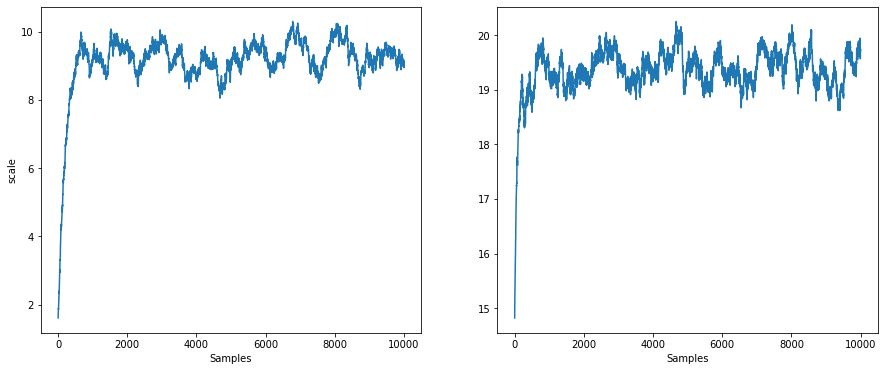

In [11]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax.set_ylabel("scale")

## NUTS

NUTS is a *dynamic* algorithm: the number of integration steps is determined at runtime. We still need to specify a step size and a mass matrix:

In [12]:
inv_mass_matrix = np.array([.5, .5])
step_size = 1e-3

In [13]:
initial_position = {"loc": 1.0, "scale": 2.0}
initial_state = nuts.new_state(initial_position, potential)
initial_state

HMCState(position={'loc': 1.0, 'scale': 2.0}, potential_energy=DeviceArray(63021.727, dtype=float32), potential_energy_grad={'loc': DeviceArray(-2266.9055, dtype=float32), 'scale': DeviceArray(-60909.64, dtype=float32)})

In [14]:
%%time
nuts_kernel = jax.jit(nuts.kernel(potential, step_size, inv_mass_matrix))

CPU times: user 662 µs, sys: 0 ns, total: 662 µs
Wall time: 492 µs


In [15]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts_kernel, initial_state, 4_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 6.89 s, sys: 30.2 ms, total: 6.92 s
Wall time: 6.93 s


Text(0, 0.5, 'scale')

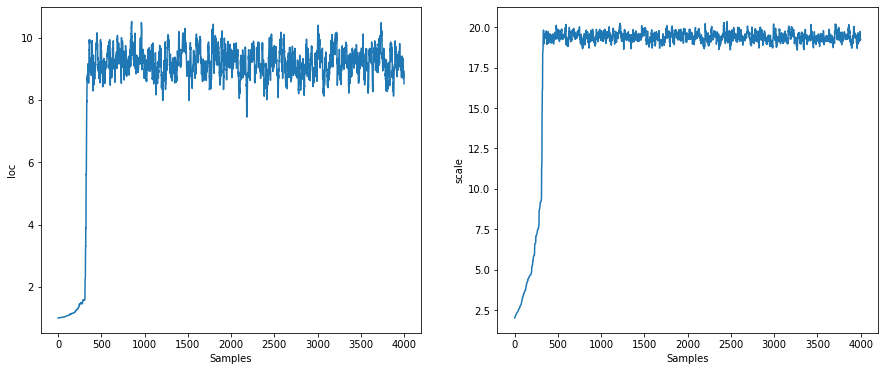

In [16]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")

### Use Stan's window adaptation

Specifying the step size and inverse mass matrix is cumbersome. We can use Stan's window adaptation to get reasonable values for them so we have, in practice, no parameter to specify.

The adaptation algorithm takes a function that returns a transition kernel given a step size and an inverse mass matrix:

In [17]:
kernel_generator = lambda step_size, inverse_mass_matrix: hmc.kernel(potential, step_size, inverse_mass_matrix, 30)

In [18]:
%%time

final_state, (step_size, inverse_mass_matrix), info = stan_warmup.run(
    rng_key,
    kernel_generator,
    initial_state,
    1000,
)

CPU times: user 1.52 s, sys: 602 µs, total: 1.52 s
Wall time: 1.52 s


We can use the obtained parameters to define a new kernel. Note that we do not have to use the same kernel that was used for the adaptation:

In [19]:
kernel = nuts.kernel(potential, step_size, inverse_mass_matrix)

In [20]:
%%time

states = inference_loop(rng_key, nuts_kernel, initial_state, 1_000)

loc_samples = states.position["loc"].block_until_ready()
scale_samples = states.position["scale"]

CPU times: user 2.55 s, sys: 11.6 ms, total: 2.56 s
Wall time: 2.52 s


Text(0, 0.5, 'scale')

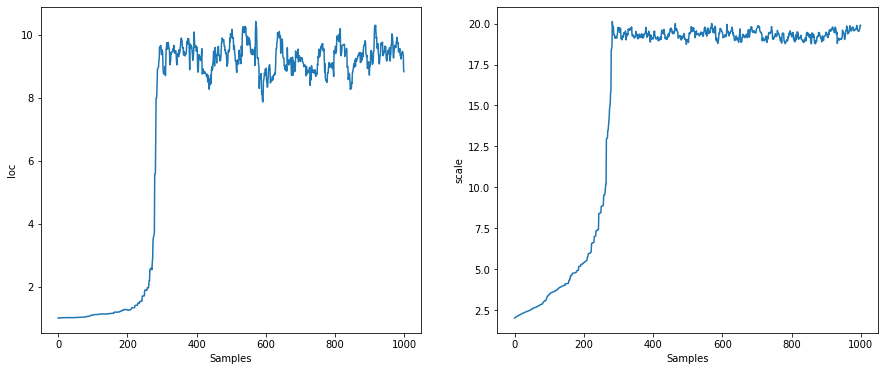

In [21]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,6))
ax.plot(loc_samples)
ax.set_xlabel("Samples")
ax.set_ylabel("loc")

ax1.plot(scale_samples)
ax1.set_xlabel("Samples")
ax1.set_ylabel("scale")

## Sample multiple chains

We can easily sample multiple chains using JAX's `vmap` construct. See the [documentation](https://jax.readthedocs.io/en/latest/jax.html?highlight=vmap#jax.vmap) to understand how the mapping works. 

In [22]:
num_chains = 4
initial_positions = {"loc": np.ones(num_chains), "scale": 2. * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(initial_positions, potential)

In [23]:
def inference_loop_multiple_chains(rng_key, kernel, initial_state, num_samples, num_chains):
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [24]:
%%time
states = inference_loop_multiple_chains(rng_key, hmc_kernel, initial_states, 2_000, num_chains)
states.position['loc'].block_until_ready()

CPU times: user 2.92 s, sys: 354 ms, total: 3.27 s
Wall time: 1.95 s


DeviceArray([[1.5866092, 1.6297967, 1.6689506, 1.672805 ],
             [1.6388961, 1.6665258, 1.6916376, 1.7755994],
             [1.6681166, 1.6963456, 1.6880739, 1.7831483],
             ...,
             [9.108203 , 9.561337 , 8.773021 , 9.108065 ],
             [9.160922 , 9.531993 , 8.755935 , 9.085443 ],
             [9.148049 , 9.531993 , 8.8065605, 9.1586   ]], dtype=float32)

This scales very well to hundreds of chains on CPU, tens of thousand on GPU:

In [25]:
%%time
num_chains = 40
initial_positions = {"loc": np.ones(num_chains), "scale": 2. * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(initial_positions, potential)
states = inference_loop_multiple_chains(rng_key, hmc_kernel, initial_states, 2_000, num_chains)
states.position['loc'].block_until_ready()

CPU times: user 20.2 s, sys: 5.54 s, total: 25.7 s
Wall time: 11 s


DeviceArray([[ 1.6188403,  1.6562082,  1.6789691, ...,  1.5876292,
               1.5872068,  1.6263773],
             [ 1.6369396,  1.7041371,  1.6566746, ...,  1.6249576,
               1.6392759,  1.6642523],
             [ 1.7056254,  1.6991565,  1.6145997, ...,  1.6861103,
               1.738116 ,  1.6794758],
             ...,
             [ 9.294902 , 10.217712 ,  8.79843  , ...,  8.833055 ,
               9.265411 ,  9.22371  ],
             [ 9.337823 , 10.310268 ,  8.755466 , ...,  8.831262 ,
               9.258809 ,  9.218547 ],
             [ 9.2746525, 10.306898 ,  8.756225 , ...,  8.831262 ,
               9.276784 ,  9.233877 ]], dtype=float32)

In [26]:
%%time
num_chains = 400
initial_positions = {"loc": np.ones(num_chains), "scale": 2. * np.ones(num_chains)}
initial_states = jax.vmap(hmc.new_state, in_axes=(0, None))(initial_positions, potential)
states = inference_loop_multiple_chains(rng_key, hmc_kernel, initial_states, 2_000, num_chains)
states.position['loc'].block_until_ready()

CPU times: user 3min 7s, sys: 12.4 s, total: 3min 19s
Wall time: 1min 29s


DeviceArray([[1.6483115, 1.5910562, 1.6310483, ..., 1.5870135, 1.6704323,
              1.6440841],
             [1.6814109, 1.6378932, 1.647786 , ..., 1.5896027, 1.718825 ,
              1.6454687],
             [1.7577739, 1.6607739, 1.7478336, ..., 1.5896027, 1.6732789,
              1.6738929],
             ...,
             [9.689667 , 8.446985 , 9.061996 , ..., 8.91248  , 8.239437 ,
              9.433724 ],
             [9.643398 , 8.456601 , 9.0272455, ..., 8.890434 , 8.157666 ,
              9.381471 ],
             [9.557168 , 8.501042 , 8.988622 , ..., 8.970274 , 8.203725 ,
              9.423823 ]], dtype=float32)

In this example the result is a dictionnary and each entry has shape `(num_samples, num_chains)`. Here's how to access the samples of the second chains for `loc`:

In [27]:
states.position['loc'][:,1]

DeviceArray([1.5910562, 1.6378932, 1.6607739, ..., 8.446985 , 8.456601 ,
             8.501042 ], dtype=float32)